# I) Packages

In [1]:
from astropy import stats
from scipy import constants
from scipy import interpolate
from scipy import optimize
from scipy import integrate
import numpy as np
import math 
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import pandas as pd
import time
from tqdm import tqdm

# II) Data  JWST

#### Connection points: (7.5,11.5,17.7)

In [2]:
#Function
def locate(arr,x): #return arr[i] just larger than x
    i = 0
    while arr[i] < x:
        i += 1
    return i

def readSpec(csvFile):
    #csvFile: objName, expt_ch1, expt_ch2, expt_ch3, expt_ch4, longitude, latitude, ...
    specFile = pd.read_csv(csvFile)
    dataInfo = np.array(specFile)
    fileNo = np.ma.size(dataInfo,axis=0)
    exptArr = np.zeros((fileNo,4))
    longArr = np.zeros(fileNo)
    latArr = np.zeros(fileNo)
    for i in range(fileNo):
        exptArr[i,0] = dataInfo[i,1]  #s
        exptArr[i,1] = dataInfo[i,2]  #s
        exptArr[i,2] = dataInfo[i,3]  #s
        exptArr[i,3] = dataInfo[i,4]  #s
        longArr[i] = dataInfo[i,5]  #rad
        latArr[i] = dataInfo[i,6]  #rad
    return exptArr, longArr, latArr
    
def dopplerSh(wvl,flux,v,err=None):
    dopplerFactor = np.sqrt((1+v/constants.c)/(1-v/constants.c))
    print('Doppler factor = ', dopplerFactor)
    new_wvl = dopplerFactor*wvl
    new_flux = np.interp(wvl, new_wvl, flux)
    new_err = np.interp(wvl, new_wvl, err)
    return wvl, new_flux, new_err

In [19]:
#Load data
stkData = np.load('stkData.npz')
wvl_ch1, flux_ch1, bkgdErr_ch1 = stkData['ch1']
wvl_ch2, flux_ch2, bkgdErr_ch2 = stkData['ch2']
wvl_ch3, flux_ch3, bkgdErr_ch3 = stkData['ch3']
wvl_ch4, flux_ch4, bkgdErr_ch4 = stkData['ch4']
exptArr, longArr, latArr = readSpec('MRS_objects.csv')
exptArr_ch1 = exptArr[:,0]
exptArr_ch2 = exptArr[:,1]
exptArr_ch3 = exptArr[:,2]
exptArr_ch4 = exptArr[:,3]

In [4]:
wvlM1 = 7.6
wvlM2 = 11.6
wvlM3 = 17.8
wvlM4 = 28.6
p2_ch1 = locate(wvl_ch1,wvlM1)+1
p1_ch2 = locate(wvl_ch2,wvlM1)
p2_ch2 = locate(wvl_ch2,wvlM2)+1
p1_ch3 = locate(wvl_ch3,wvlM2) 
p2_ch3 = locate(wvl_ch3,wvlM3)+1
p1_ch4 = locate(wvl_ch4,wvlM3) 
p2_ch4 = locate(wvl_ch4,wvlM4)

In [5]:
#Truncated spectrums
wvl_ch1_t = wvl_ch1[:p2_ch1]
wvl_ch2_t = wvl_ch2[p1_ch2:p2_ch2]
wvl_ch3_t = wvl_ch3[p1_ch3:p2_ch3]
wvl_ch4_t = wvl_ch4[p1_ch4:p2_ch4]

flux_ch1_t = flux_ch1[:p2_ch1]
flux_ch2_t = flux_ch2[p1_ch2:p2_ch2]
flux_ch3_t = flux_ch3[p1_ch3:p2_ch3]
flux_ch4_t = flux_ch4[p1_ch4:p2_ch4]

bkgdErr_ch1_t = bkgdErr_ch1[:p2_ch1]
bkgdErr_ch2_t = bkgdErr_ch2[p1_ch2:p2_ch2]
bkgdErr_ch3_t = bkgdErr_ch3[p1_ch3:p2_ch3]
bkgdErr_ch4_t = bkgdErr_ch4[p1_ch4:p2_ch4]

print('Matching points:')
print(wvl_ch1_t[-1],wvl_ch2_t[0])
print(wvl_ch2_t[-1],wvl_ch3_t[0])
print(wvl_ch3_t[-1],wvl_ch4_t[0])

Matching points:
7.60040002714959 7.600350229127798
11.60045024001738 11.601250189589337
17.801250051008537 17.80500076385215


In [6]:
#Locate a segment
p1 = locate(wvl_ch1,5.350) 
p2 = locate(wvl_ch1,5.525)
wvlCut = wvl_ch1[p1:p2]
fluxCut = flux_ch1[p1:p2]
errorCut = bkgdErr_ch1[p1:p2]

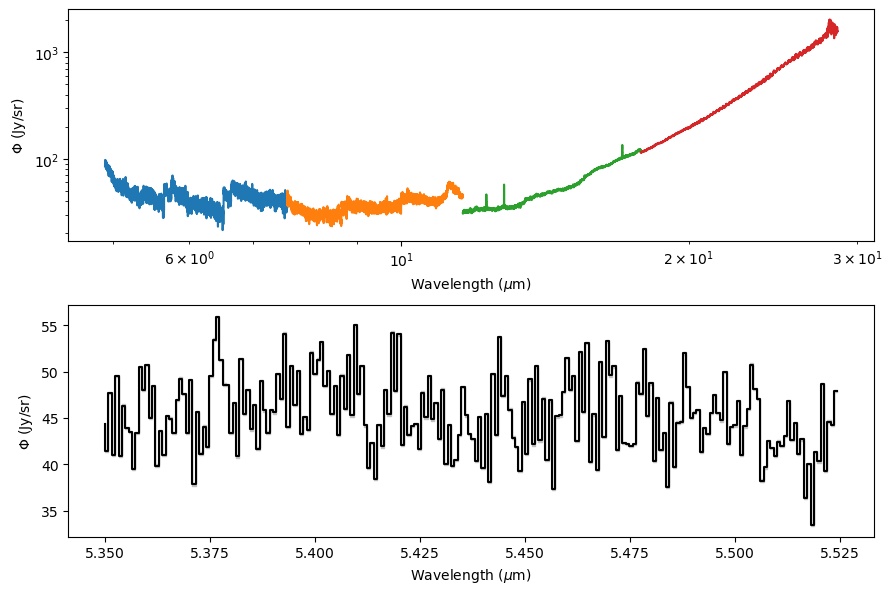

In [7]:
#Spectrum plot
plt.figure(figsize=(9,6))

plt.subplot(211)  
plt.step(wvl_ch1_t,flux_ch1_t)
plt.step(wvl_ch2_t,flux_ch2_t)
plt.step(wvl_ch3_t,flux_ch3_t)
plt.step(wvl_ch4_t,flux_ch4_t)
plt.xlabel("Wavelength ($\\mu$m)")
plt.ylabel("$\\Phi$ (Jy/sr)")
plt.xscale('log')
plt.yscale('log')
#plt.ylim(0, 0.3)

plt.subplot(212)
plt.step(wvlCut,fluxCut,'black')
plt.fill_between(wvlCut,fluxCut+errorCut,fluxCut-errorCut,step="pre",color='silver')
#plt.ylim(0.08,0.14)
plt.xlabel("Wavelength ($\\mu$m)")
plt.ylabel("$\\Phi$ (Jy/sr)")
plt.tight_layout(pad=0.9)

# III) Data analysis 

### Functions and Parameters

In [8]:
#Parameters
J_to_GeV = 6.242  #1e9
kpc_to_cm = 3.086e12  #1e9
rho_s = 0.18  #GeV/cm^3
rs = 24  #kpc
R_sun = 8.27  #kpc
sigma_v = 160000/constants.c #m/s/c
solarV = 250000 #m/s

#Conversion: mass (eV) <=> wavelength (um)
def massToWvl(m):
    return 2*constants.Planck*constants.c/m/constants.e/1e-6

def wvlToMass(wvl):
    return 2*constants.Planck*constants.c/wvl/constants.e/1e-6

def couplingToGamma(g,ma):  #GeV-1 => s-1
    return g**2*ma**3/64/np.pi/658.2119569

def gammaToCoupling(gamma,ma):  #s-1 => GeV-1
    return np.sqrt(64*math.pi*658.2119569*gamma/ma**3)

#FWHM estimation:
def FWHMestim(S_spec,M_spec,L_spec):
    Swvl = np.mean(S_spec[:2])
    Mwvl = np.mean(M_spec[:2])
    Lwvl = np.mean(L_spec[:2])
    Sres = np.mean(S_spec[2:])
    Mres = np.mean(M_spec[2:])
    Lres = np.mean(L_spec[2:])
    return (Swvl/Sres+Mwvl/Mres+Lwvl/Lres)/3

In [9]:
def minimization(x,y,BOUND=(-1e9,1e9)):
    f = interpolate.interp1d(x,y)
    F = lambda x : float(f(x))
    min = optimize.minimize_scalar(F,bounds=BOUND)
    return min.x, min.fun
    
class line_model:

    def __init__(self,longArr,latArr):
        self.longArr = longArr
        self.latArr = latArr
        self.fileNo = len(longArr)
        self.D = integrate.quad_vec(self.NFW_profile,0,np.inf)[0]*(kpc_to_cm/J_to_GeV)*1e18  #TJy/sr 
        self.solarLosV = solarV*np.sin(self.longArr)*np.cos(self.latArr) 
        self.dopplerFac = np.sqrt((1-self.solarLosV/constants.c)/(1+self.solarLosV/constants.c))
    
    #NFW profile in terms of observing distance:
    def NFW_profile(self,s):
        r_rs = np.sqrt(R_sun*R_sun+s*s-s*R_sun*np.cos(self.longArr)*np.cos(self.latArr))/rs
        return rho_s/(r_rs+r_rs*r_rs)

    def theoFlux(self,wvl,lmd0,delta_lmd,gamma,exptArr):
        
        w = lmd0*sigma_v  #um
        sigma_lmd = delta_lmd/2/np.sqrt(2*np.log(2))  #um
        newSigma2 = sigma_lmd*sigma_lmd+w*w  #um^2 
        normalize = lmd0*lmd0/np.sqrt(2*math.pi*newSigma2)/constants.c
        # print('###########################')
        # print('w = ', w)
        # print('sigma_lmd', sigma_lmd)
        # print('sigma = ', np.sqrt(newSigma2))
        # print('normalize = ', normalize)
        # print('###########################')
        
        spectrum_eff = np.zeros(len(wvl))
        weight = exptArr/np.sum(exptArr)
        for i in range(self.fileNo):
            shftWvl = wvl/self.dopplerFac[i]
            spectrum_eff += self.D[i]*normalize*np.exp(-(shftWvl-lmd0)**2/2/newSigma2)*weight[i] #us
        fluxArr = gamma*spectrum_eff/4/math.pi
        return fluxArr
    
def chi2MinusFour_conservative(obsWvl,obsFlux,obsError,gammaArr,delta_lmd,exptArr):  #output (chi2 - 4) in the searching space of gamma and lamda0
    start = time.time()
    chi2M4 = np.zeros((len(gammaArr),len(obsWvl)))
    testRange = 150  # ~75FWHM of the DM line

    for i in range(len(obsWvl)):
        lmd0 = obsWvl[i]
        #Analyse a subregion with width=150*FHWM:
        if (i>=testRange) & (i<=len(obsWvl)-testRange):
            wvl = obsWvl[i-testRange:i+testRange]
            flux = obsFlux[i-testRange:i+testRange]
            error = obsError[i-testRange:i+testRange]
        elif (i<testRange):
            wvl = obsWvl[:testRange*2]
            flux = obsFlux[:testRange*2]
            error = obsError[:testRange*2]
        elif (i>len(obsWvl)-testRange):
            wvl = obsWvl[-testRange*2:]
            flux = obsFlux[-testRange*2:]
            error = obsError[-testRange*2:]

        for j in range(len(gammaArr)):
            gamma = gammaArr[j]
            flux_model = LM.theoFlux(wvl,lmd0,delta_lmd,gamma,exptArr)
            chi2M4[j,i] = np.sum(((flux_model-flux)/error)**2,where=(flux_model-flux)>0) - 4 #[flux] = MJy/sr
            
    end = time.time()
    print('Duration: ', (end - start)/60, ' [min]')
    return chi2M4

def extractBound(wvl,gammaTest,chi2Minus4,c):  #chi2Minus4: row=gamma, column=wvl
    gammaBound = np.zeros(len(wvl))
    for i in range(len(wvl)):
        gammaBound[i] = np.interp(c,chi2Minus4[:,i],gammaTest)
    return gammaBound

In [96]:
class continuumFitting:  #gammaArr has to be monotonically increasing
    
    def __init__(self,obsWvl,obsFlux,obsError,delta_lmd, exptArr):
        self.step = 6 #3  #scanning the entire mass range in the given step (~FWHM of DM line)
        self.maskRange = 1  
        self.wvl = obsWvl
        self.flux = obsFlux
        self.error = obsError
        self.delta_lmd = delta_lmd  #FWHM instrumental resolution
        self.exptArr = exptArr
        self.lenWvl = len(obsWvl)  #length of the input wavelength array
        self.wvl_bd = obsWvl[::self.step]  #wavelength array that corresponds to the testing masses
        self.test_len = len(self.wvl_bd)  #length of the testing wavelength array
        print('No. of test masses: ', self.test_len)
    
    def continuum(self,beta,wvl):
        wvlSpline = np.linspace(wvl[0],wvl[-1],len(beta))
        return interpolate.CubicSpline(wvlSpline,beta)(wvl)

    def lnlike_continuum(self,lmd0,gamma,beta,wvl,flux,error,mask=None):
        flux_model = LM.theoFlux(wvl,lmd0,self.delta_lmd,gamma,self.exptArr) + self.continuum(beta,wvl)
        return np.sum(((flux_model-flux)/error)**2,where=(mask==False)) 

    #Changed the formula for clipped std
    def clipSD_error(self, flux, contin_model, wvl, lmd0):
        clip_sd = np.std(flux-contin_model)
        Dclip_sd = clip_sd
        i_unmask = self.maskRange + 1
        iter_threshold = clip_sd*0.01
        mask_condition = np.zeros(len(flux),dtype=bool)
        while (Dclip_sd>iter_threshold):
            upperLim = np.mean(flux-contin_model,where=(mask_condition==False)) + 3*clip_sd
            for i in range(self.maskRange,len(flux)-self.maskRange):
                if (abs(wvl[i]==lmd0)):
                    i_unmask = i
                if (np.all(abs(flux-contin_model)[i-self.maskRange:i+self.maskRange+1] >= upperLim)):
                    mask_condition[i-self.maskRange:i+self.maskRange] = True
            _,_,clip_sd_new = stats.sigma_clipped_stats(flux-contin_model,mask=mask_condition)
            Dclip_sd = clip_sd - clip_sd_new
            clip_sd = clip_sd_new
        if (wvl[self.maskRange]>=lmd0):
            i_unmask = self.maskRange + 1  
        elif (wvl[len(flux)-self.maskRange-1]<=lmd0):
            i_unmask = len(flux)-self.maskRange-2
        mask_condition[i_unmask-self.maskRange-1:i_unmask+self.maskRange+2] = False  #unmask a range of 5 bins
        return clip_sd, mask_condition

    def model_range(self,wvl,flux,error,i,testRange):
        if (self.step*i>=testRange) & (self.step*i<=self.lenWvl-testRange):
                wvlCut = self.wvl[self.step*i-testRange:self.step*i+testRange]
                fluxCut = self.flux[self.step*i-testRange:self.step*i+testRange]
                errorCut = self.error[self.step*i-testRange:self.step*i+testRange]
        elif (self.step*i<testRange):
            wvlCut = self.wvl[:testRange*2]
            fluxCut = self.flux[:testRange*2]
            errorCut = self.error[:testRange*2]
        elif (self.step*i>self.lenWvl-testRange):
            wvlCut = self.wvl[-testRange*2:]
            fluxCut = self.flux[-testRange*2:]
            errorCut = self.error[-testRange*2:]
        return wvlCut,fluxCut,errorCut
        
    def minChi2_continuum(self, lmd0, gammaArr, wvl, flux, error):
        chi2 = np.zeros(len(gammaArr))
        minBeta = np.zeros((len(gammaArr),5))
        initial = np.linspace(flux[0],flux[-1],5)

        ##################################

        likelihood = lambda beta : self.lnlike_continuum(lmd0, gammaArr[0], beta, wvl, flux, error)
        minLike = optimize.minimize(likelihood,initial)
        clip_sd, maskCondition = self.clipSD_error(flux,self.continuum(minLike.x,wvl),wvl,lmd0)
        errorFactor = np.mean(clip_sd/error)
        error_new = error*errorFactor
    
        for i in range(len(gammaArr)):
            gamma = gammaArr[i]
            likelihood = lambda beta : self.lnlike_continuum(lmd0, gamma, beta, wvl, flux, error_new, mask=maskCondition)
            minLike = optimize.minimize(likelihood,initial)
            minBeta[i,:] = minLike.x
            chi2[i] = minLike.fun
        return chi2, minBeta, error_new, errorFactor, maskCondition
        
    def constraints_continuum(self,gammaArr):
        start = time.time()
        testRange = 150  # ~75FWHM of the DM line
        error_new = np.zeros((self.test_len,testRange*2))
        chi2 = np.zeros((self.test_len,len(gammaArr)))  #Minimized wrt beta
        minBeta = np.zeros((self.test_len,len(gammaArr),5))
        errorFactor = np.zeros(self.test_len)
        mask = np.zeros((self.test_len,testRange*2))

        for i in tqdm(range(self.test_len)):
            lmd0 = self.wvl_bd[i]
            #Model a subinterval with width=150*FHWM:
            wvlCut, fluxCut, errorCut = self.model_range(self.wvl,self.flux,self.error,i,testRange)
            chi2[i,:], minBeta[i,:,:], error_new[i,:], errorFactor[i], mask[i,:] = self.minChi2_continuum(lmd0,gammaArr, wvlCut, fluxCut, errorCut)
            
        end = time.time()
        print('Duration: ', (end - start)/60, ' [min]')
        self.chisq = chi2
        self.beta = minBeta
        self.errorNew = error_new
        return chi2, minBeta, error_new, errorFactor, mask

    # def bestFit(self,lmd0,gammaArr,chi2,wvl,flux,error):
    #     gamma_bf,like_bf = minimization(gammaArr,chi2,BOUND=(0,gammaArr[np.argmin(chi2)+5]))
    #     initial = np.linspace(flux[0],flux[-1],5)
    #     likelihood = lambda beta : self.lnlike_continuum(lmd0, gamma_bf, beta, wvl, flux, error)
    #     minLike = optimize.minimize(likelihood,initial)
    #     minBeta = optimize.minimize(likelihood,initial).x
    #     return np.append(gamma_bf,minBeta), minLike.fun

    def detection_signif(self,chi2,gammaArr):
        N2 = np.min(chi2,axis=1) - chi2[:,0]
        return N2
        
    def extractBound_continuum(self,chi2,gammaArr,c):
        gammaBound = np.zeros(self.test_len)
        for i in range(self.test_len):
            min_i = np.argmin(chi2[i,:])
            d_chi2 = chi2[i,:] - np.min(chi2[i,:])
            gammaBound[i] = np.interp(c,d_chi2[min_i:],gammaArr[min_i:])
        return gammaBound

    def fitting_result(self, gammaArr, plot_i=0, plotFit=False, yLIM=(0,12), gamma_LIM=(0,5e-24), chi2_LIM=(0,5), CHISQ=np.array([]), BETA=np.array([]), ERRNEW=np.array([])):
        #data=[chi2,beta,error_new]
        #Input data:
        if (CHISQ.size==0):
            CHISQ=self.chisq, BETA=minBeta, ERRNEW=self.errorNew
            
        #Detection significance:
        n2 = self.detection_signif(CHISQ,gammaArr)
        plt.figure(figsize=(12,4))
        plt.plot(self.wvl_bd,np.sqrt(-n2))
        plt.ylim(yLIM)
        plt.axhline(y = 5, color = 'grey', linestyle = '--') 
        plt.xlabel('Wavelength ($\\mu$m)')
        plt.ylabel('|N|')
        plt.show()
        print('Significant detection:')
        for i in range(len(n2)):
            if np.sqrt(-n2[i])>5:
                print('N =', "{:.2f}".format(np.sqrt(-n2[i])), 'at (\u03BB_0,i) =', ("{:.2f}".format(self.wvl_bd[i]),i))
        min_i = np.argmin(n2)
        print('Strongest detection:')
        print('N =', "{:.2f}".format(np.sqrt(-n2[min_i])), 'at (\u03BB_0,i) =', ("{:.2f}".format(self.wvl_bd[min_i]),min_i))
        
        #Fitting result at specific lambda:
        if (plotFit == True):
            plt.figure(figsize=(12, 9))
            
            #Spectrum:
            testRange = 150  # ~75FWHM of the DM line
            wvl_model, flux_model, error_model = self.model_range(self.wvl,self.wvl,self.error,plot_i,testRange)  
            gamma_min_i = np.argmin(CHISQ[plot_i,:])
            theta_min  = np.append(gammaArr[gamma_min_i],BETA[plot_i,gamma_min_i,:])
            best_fit_model = best_fit_model = LM.theoFlux(wvl_model,self.wvl_bd[plot_i],self.delta_lmd,theta_min[0],self.exptArr) + self.continuum(theta_min[1:],wvl_model)

            plt.subplot(211)
            plt.plot(wvl_model,best_fit_model, color='red')
            plt.plot(wvl_model,self.continuum(BETA[plot_i,0,:],wvl_model), color='blue')
            plt.step(wvl_model,flux_model,'black')
            plt.fill_between(wvl_model,flux_model+ERRNEW[plot_i],flux_model-ERRNEW[plot_i],step="pre",color='silver')
            plt.legend(('Best fit', 'Null'))
            #plt.ylim(0.08,0.14)
            plt.xlabel('Wavelength ($\\mu$m)')
            plt.ylabel("$\\Phi$ (MJy/sr)")

            #Chi2 against gamma
            plt.subplot(212)
            plt.plot(gammaArr,CHISQ[plot_i,:]/2/testRange,'-o')
            plt.axhline(y = CHISQ[plot_i,0]/2/testRange, color = 'grey', linestyle = '--') 
            plt.ylim(chi2_LIM)
            plt.xlim(gamma_LIM)
            plt.xlabel('$\\Gamma$ (Hz)')
            plt.ylabel('$\\chi^2$/dof')
            plt.show() 
            print('Parameters:', theta_min)
            print('chi2 =', np.min(CHISQ[plot_i,:]), 'N =', np.sqrt(-n2[plot_i]))

### Theoretical DM flux

In [97]:
massArr_ch1 = wvlToMass(wvl_ch1_t)  
massArr_ch2 = wvlToMass(wvl_ch2_t) 
massArr_ch3 = wvlToMass(wvl_ch3_t)  
massArr_ch4 = wvlToMass(wvl_ch4_t) 

In [98]:
S_spec_ch1 = np.array([4.9,5.74,3320,3710])
M_spec_ch1 = np.array([5.66,6.63,3190,3750])
L_spec_ch1 = np.array([6.53,7.65,3100,3610])
S_spec_ch2 = np.array([7.51,8.77,2990,3110])
M_spec_ch2 = np.array([8.67,10.13,2750,3170])
L_spec_ch2 = np.array([10.02,11.70,2860,3300])
S_spec_ch3 = np.array([11.55,13.47,2530,2880])
M_spec_ch3 = np.array([13.34,15.57,1790,2640])
L_spec_ch3 = np.array([15.41,17.98,1980,2790])
S_spec_ch4 = np.array([17.70,20.95,1460,1930])
M_spec_ch4 = np.array([20.69,24.48,1680,1770])
L_spec_ch4 = np.array([24.19,27.90,1630,1330])

In [99]:
#Parameters
d_lmd_ch1 = FWHMestim(S_spec_ch1,M_spec_ch1,L_spec_ch1)  #um
d_lmd_ch2 = FWHMestim(S_spec_ch2,M_spec_ch2,L_spec_ch2)  #um
d_lmd_ch3 = FWHMestim(S_spec_ch3,M_spec_ch3,L_spec_ch3)  #um
d_lmd_ch4 = FWHMestim(S_spec_ch4,M_spec_ch4,L_spec_ch4)  #um
print('d_lmd =', d_lmd_ch1,d_lmd_ch2,d_lmd_ch3,d_lmd_ch4)

d_lmd = 0.0017992235568887905 0.003123500720222032 0.006050242771447129 0.014030635512388109


#### Remark: 1) The response function and the FWHM resolution are approximate and not optimized. 2) The data has a long exposure exposure time but a short integration (about 70s). (what's the effect?)

lambda_0 (um) =  5.460400081210537 , ma (eV) =  0.45412129730140116
g (GeV-1)  =  4e-09 , gamma (Hz) =  1.1322438703376422e-23
[1.00012364 1.00012389]


Text(0, 0.5, '$\\Phi$ (MJy/sr)')

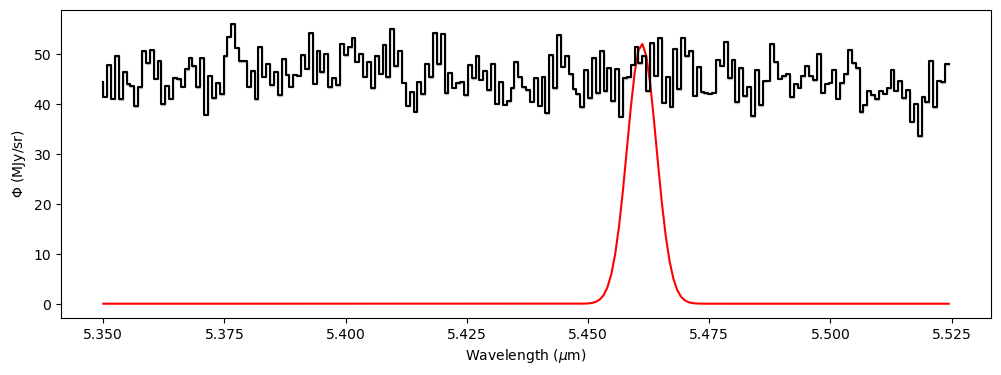

In [37]:
#Test Params
lmd0_test = wvlCut[locate(wvlCut,5.46)]
ma_test = wvlToMass(lmd0_test)
g_test = 4e-9  #GeV-1
gamma_test = couplingToGamma(g_test,ma_test)
print('lambda_0 (um) = ', lmd0_test, ', ma (eV) = ', ma_test)
print('g (GeV-1)  = ', g_test, ', gamma (Hz) = ', gamma_test)

#Results
LM = line_model(latArr,longArr)
print(LM.dopplerFac)
theoFlux_test = LM.theoFlux(wvlCut,lmd0_test,d_lmd_ch1,gamma_test,exptArr_ch1)
plt.figure(figsize=(12,4))
plt.plot(wvlCut,theoFlux_test,color='red')
plt.step(wvlCut,fluxCut,'black')
plt.fill_between(wvlCut,fluxCut+errorCut,fluxCut-errorCut,step="pre",color='silver')
plt.xlabel('Wavelength ($\\mu$m)')
plt.ylabel('$\\Phi$ (MJy/sr)')
#plt.ylim(0,0.005)

### Conservative constraint

In [52]:
gammaTest1 = np.logspace(-24,np.log10(3e-23),600)
gammaTest2 = np.logspace(np.log10(8e-25),-23,600)
gammaTest3 = np.logspace(np.log10(2e-24),-23,800)
gammaTest4 = np.logspace(np.log10(5e-24),-22,1800)
chi2M4_1 = chi2MinusFour_conservative(wvl_ch1_t,flux_ch1_t,bkgdErr_ch1_t,gammaTest1,d_lmd_ch1,exptArr_ch1)
chi2M4_2 = chi2MinusFour_conservative(wvl_ch2_t,flux_ch2_t,bkgdErr_ch2_t,gammaTest2,d_lmd_ch2,exptArr_ch2)
chi2M4_3 = chi2MinusFour_conservative(wvl_ch3_t,flux_ch3_t,bkgdErr_ch3_t,gammaTest3,d_lmd_ch3,exptArr_ch3)
chi2M4_4 = chi2MinusFour_conservative(wvl_ch4_t,flux_ch4_t,bkgdErr_ch4_t,gammaTest4,d_lmd_ch4,exptArr_ch4)

Duration:  1.6642240683237712  [min]
Duration:  1.6376421848932903  [min]
Duration:  1.6527496814727782  [min]
Duration:  2.728648070494334  [min]


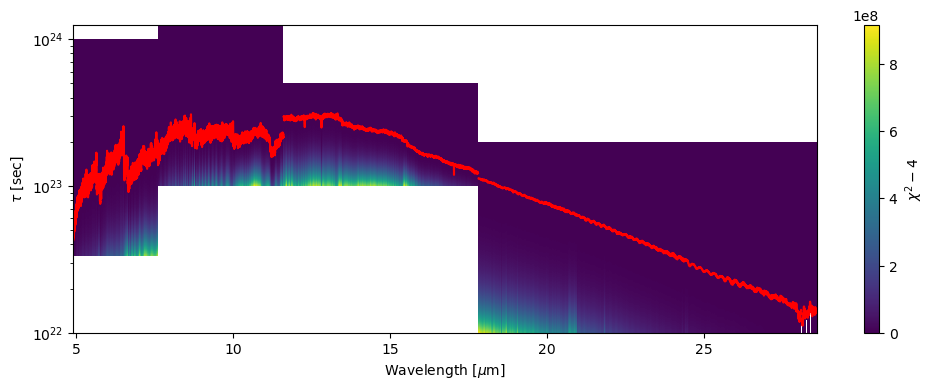

In [65]:
#Plot
wvl1, gammaTest_1 = np.meshgrid(wvl_ch1_t,gammaTest1)
wvl2, gammaTest_2 = np.meshgrid(wvl_ch2_t,gammaTest2)
wvl3, gammaTest_3 = np.meshgrid(wvl_ch3_t,gammaTest3)
wvl4, gammaTest_4 = np.meshgrid(wvl_ch4_t,gammaTest4)
plt.figure(figsize=(12,4))
plt.pcolormesh(wvl1, 1/gammaTest_1, chi2M4_1)
plt.pcolormesh(wvl2, 1/gammaTest_2, chi2M4_2)
plt.pcolormesh(wvl3, 1/gammaTest_3, chi2M4_3)
plt.pcolormesh(wvl4, 1/gammaTest_4, chi2M4_4)
plt.colorbar(label='$\\chi^2-4$')
plt.contour(wvl1, 1/gammaTest_1, chi2M4_1, 0, colors='red')
plt.contour(wvl2, 1/gammaTest_2, chi2M4_2, 0, colors='red')
plt.contour(wvl3, 1/gammaTest_3, chi2M4_3, 0, colors='red')
plt.contour(wvl4, 1/gammaTest_4, chi2M4_4, 0, colors='red')
plt.xlabel('Wavelength [$\\mu$m]')
plt.ylabel('$\\tau$ [sec]')
plt.yscale('log')
plt.show()

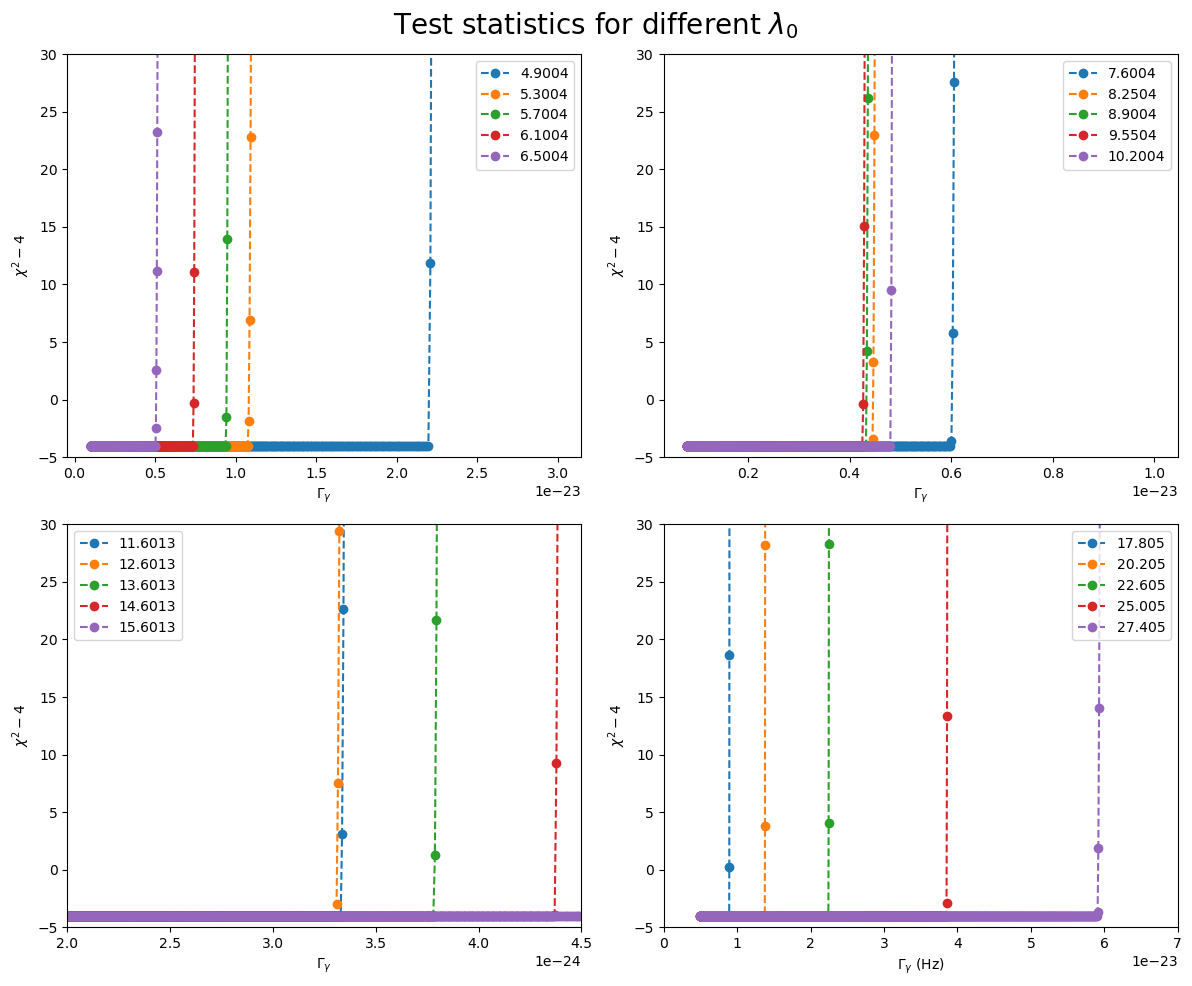

In [54]:
fig = plt.figure(figsize=(12,10))
fig.suptitle('Test statistics for different $\\lambda_0$', fontsize=20)

step = 500
ax1 = plt.subplot(221)
for i in range(5):
    ax1.plot(gammaTest1,chi2M4_1[:,i*step],'--o')
ax1.legend(np.round(wvl_ch1_t[:4*step+1][::step],4))
ax1.set_ylim(-5,30)
ax1.set_xlabel('$\\Gamma_\\gamma$')
ax1.set_ylabel('$\\chi^2 - 4$')

step = 500
ax2 = plt.subplot(222)
for i in range(5):
    ax2.plot(gammaTest2,chi2M4_2[:,i*step],'--o')
ax2.legend(np.round(wvl_ch2_t[:4*step+1][::step],4))
#plt.xlim(3e-23,5e-23)
ax2.set_ylim(-5,30)
ax2.set_xlabel('$\\Gamma_\\gamma$')
ax2.set_ylabel('$\\chi^2 - 4$')

step = 400
ax3 = plt.subplot(223)
for i in range(5):
    ax3.plot(gammaTest3,chi2M4_3[:,i*step],'--o')
ax3.legend(np.round(wvl_ch3_t[:4*step+1][::step],4))
ax3.set_xlim(0.2e-23,0.45e-23)
ax3.set_ylim(-5,30)
ax3.set_xlabel('$\\Gamma_\\gamma$')
ax3.set_ylabel('$\\chi^2 - 4$')

step = 400
ax4 = plt.subplot(224)
for i in range(5):
    ax4.plot(gammaTest4,chi2M4_4[:,i*step],'--o')
ax4.legend(np.round(wvl_ch4_t[:4*step+1][::step],4))
plt.xlim(0,0.7e-22)
ax4.set_ylim(-5,30)
ax4.set_xlabel('$\\Gamma_\\gamma$ (Hz)')
ax4.set_ylabel('$\\chi^2 - 4$')
plt.tight_layout(pad=1)
plt.savefig('conserv_Chi2_agst_gamma.pdf')

In [55]:
#Flux-to-error ratio
print(np.mean(fluxCut/errorCut))
print(np.mean(flux_ch1_t/bkgdErr_ch1_t))
print(np.mean(flux_ch2_t/bkgdErr_ch2_t))
print(np.mean(flux_ch3_t/bkgdErr_ch3_t))
print(np.mean(flux_ch4_t/bkgdErr_ch4_t))

350.16869418358755
430.654392303517
646.4035705019443
1785.6921426300144
nan


Q: Why is the chi2 value increases so rapidly with gamma (compared with what we see for the old set of data)? 
A: It is probably due to the higher flux-to-error ratio compared to the previous set of data (current 170, previous 110). The above list of numbers agree perfectly with the observed trend.

In [56]:
#Extract bounds
gammaBd_ch1 = extractBound(wvl_ch1_t,gammaTest1,chi2M4_1,0)
gammaBd_ch2 = extractBound(wvl_ch2_t,gammaTest2,chi2M4_2,0)
gammaBd_ch3 = extractBound(wvl_ch3_t,gammaTest3,chi2M4_3,0)
gammaBd_ch4 = extractBound(wvl_ch4_t,gammaTest4,chi2M4_4,0)
couplingBd_ch1 = gammaToCoupling(gammaBd_ch1,massArr_ch1)
couplingBd_ch2 = gammaToCoupling(gammaBd_ch2,massArr_ch2)
couplingBd_ch3 = gammaToCoupling(gammaBd_ch3,massArr_ch3)
couplingBd_ch4 = gammaToCoupling(gammaBd_ch4,massArr_ch4)

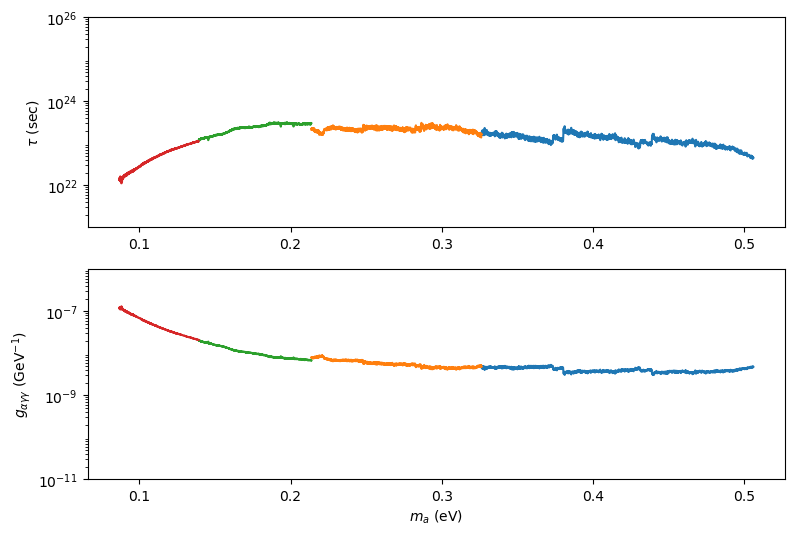

In [57]:
#Constraint plots
plt.figure(figsize=(9,6))
plt.subplot(211) 
plt.plot(massArr_ch1,1/gammaBd_ch1)
plt.plot(massArr_ch2,1/gammaBd_ch2)
plt.plot(massArr_ch3,1/gammaBd_ch3)
plt.plot(massArr_ch4,1/gammaBd_ch4)
plt.yscale('log')
plt.ylabel('$\\tau$ (sec)')
plt.ylim(1e21,1e26)
plt.yticks([1e22,1e24,1e26])

plt.subplot(212)
plt.plot(massArr_ch1,couplingBd_ch1)
plt.plot(massArr_ch2,couplingBd_ch2)
plt.plot(massArr_ch3,couplingBd_ch3)
plt.plot(massArr_ch4,couplingBd_ch4)
plt.yscale('log')
plt.xlabel('$m_a$ (eV)')
plt.ylabel('$g_{\\alpha\\gamma\\gamma}$ (GeV$^{-1}$)')
plt.ylim(1e-11,1e-6)
plt.yticks([1e-11,1e-9,1e-7])
plt.savefig('conservConstraint.pdf')
plt.show()

### Continuum constriants

In [71]:
lmd0_test = wvlCut[locate(wvlCut,5.443)-3]
fc = continuumFitting(wvlCut,fluxCut,errorCut,d_lmd_ch1,exptArr_ch1)
gammaCut = np.append(0,np.logspace(-25,np.log10(5e-24),100))
chi2Cut, betaCut, errorCut_new, errorFac_cut, mask_cut= fc.minChi2_continuum(lmd0_test,gammaCut,wvlCut,fluxCut,errorCut)

No. of test masses:  37


(0.7, 0.9)

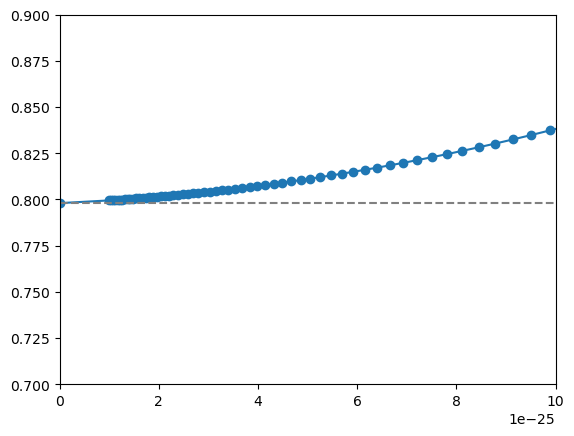

In [63]:
plt.plot(gammaCut,chi2Cut/len(wvlCut),'-o')
plt.axhline(y = chi2Cut[0]/len(wvlCut), color = 'grey', linestyle = '--') 
plt.xlim(0,1e-24)
plt.ylim(0.7,0.9)

[ 0.         42.99399455 47.0125824  45.0515952  45.34793856 40.82987602]
likelihood =  174.74660818404465 g =  0.0
[6.40592308e-25 4.27239678e+01 4.70448415e+01 4.45526035e+01
 4.52965756e+01 4.06538819e+01]
likelihood =  178.9559891457875 g =  9.51438808141354e-10


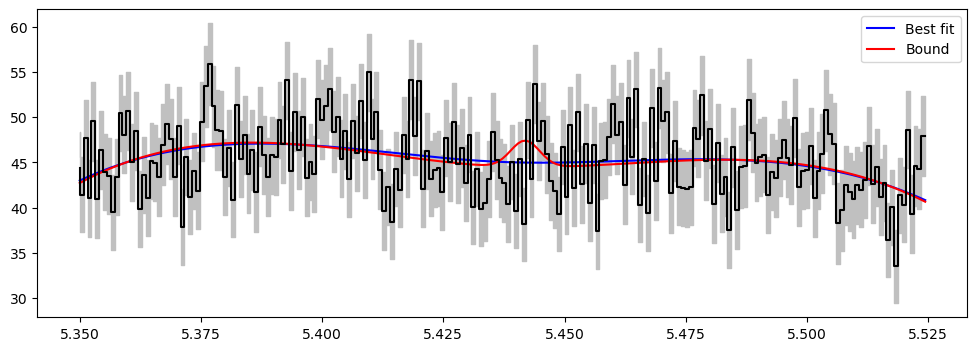

In [48]:
theta_min = np.append(gammaCut[np.argmin(chi2Cut)],betaCut[np.argmin(chi2Cut),:])
best_fit_model = LM.theoFlux(wvlCut,lmd0_test,d_lmd_ch1,theta_min[0],exptArr[:,0]) + fc.continuum(theta_min[1:],wvlCut)
print(theta_min)
print('likelihood = ', np.min(chi2Cut), 'g = ', gammaToCoupling(theta_min[0],ma_test))

gammaBd = np.interp(4,chi2Cut[np.argmin(chi2Cut):] - np.min(chi2Cut),gammaCut[np.argmin(chi2Cut):])
i_bd = locate(gammaCut,gammaBd)
theta_bd  = np.append(gammaCut[i_bd],betaCut[i_bd,:])
bound_model = LM.theoFlux(wvlCut,lmd0_test,d_lmd_ch1,theta_bd[0],exptArr[:,0]) + fc.continuum(theta_bd[1:],wvlCut)
print(theta_bd)
print('likelihood = ', chi2Cut[i_bd], 'g = ', gammaToCoupling(theta_bd[0],ma_test))

plt.figure(figsize=(12, 4))
plt.plot(wvlCut,best_fit_model, color='blue')
plt.plot(wvlCut,bound_model, color='red')
plt.step(wvlCut,fluxCut,'black')
plt.fill_between(wvlCut,fluxCut+errorCut_new,fluxCut-errorCut_new,step="pre",color='silver')
#plt.ylim(15,40)
plt.legend(('Best fit', 'Bound'))
plt.show()

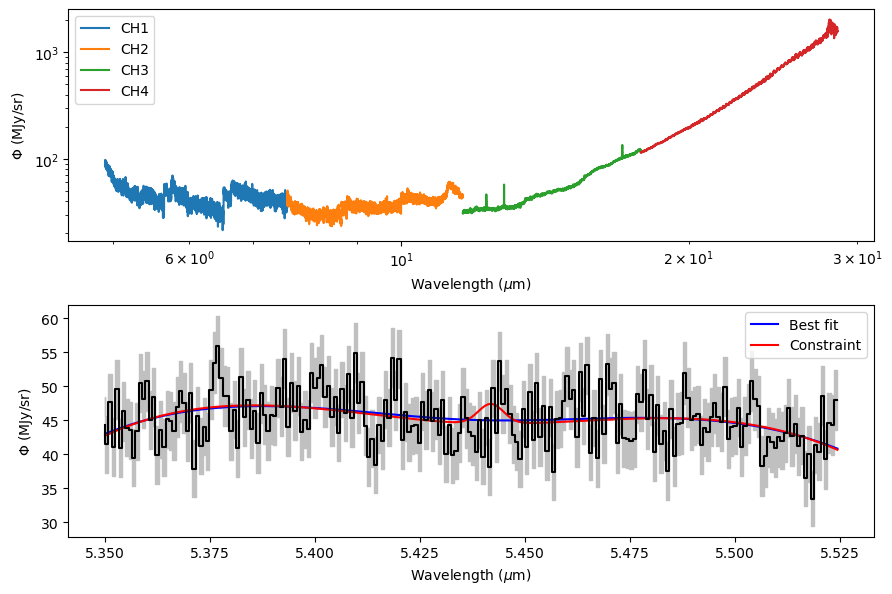

In [59]:
plt.figure(figsize=(9,6))
plt.subplot(211)  
plt.step(wvl_ch1_t,flux_ch1_t)
plt.step(wvl_ch2_t,flux_ch2_t)
plt.step(wvl_ch3_t,flux_ch3_t)
plt.step(wvl_ch4_t,flux_ch4_t)
plt.xscale('log')
plt.yscale('log')
plt.legend(('CH1','CH2','CH3','CH4'))
plt.xlabel("Wavelength ($\\mu$m)")
plt.ylabel("$\\Phi$ (MJy/sr)")

plt.subplot(212)
plt.plot(wvlCut,best_fit_model, color='blue')
plt.plot(wvlCut,bound_model, color='red')
plt.step(wvlCut,fluxCut,'black')
plt.fill_between(wvlCut,fluxCut+errorCut_new,fluxCut-errorCut_new,step="pre",color='silver')
#plt.ylim(15,40)
plt.xlabel("Wavelength ($\\mu$m)")
plt.ylabel("$\\Phi$ (MJy/sr)")
plt.legend(('Best fit', 'Constraint'))
plt.tight_layout(pad=0.9)
#plt.savefig("TCha_spectrum2.pdf")
plt.show()

#### Full-range analysis

In [100]:
fc1 = continuumFitting(wvl_ch1_t,flux_ch1_t,bkgdErr_ch1_t,d_lmd_ch1,exptArr_ch1)
fc2 = continuumFitting(wvl_ch2_t,flux_ch2_t,bkgdErr_ch2_t,d_lmd_ch2,exptArr_ch2)
fc3 = continuumFitting(wvl_ch3_t,flux_ch3_t,bkgdErr_ch3_t,d_lmd_ch3,exptArr_ch3)
fc4 = continuumFitting(wvl_ch4_t,flux_ch4_t,bkgdErr_ch4_t,d_lmd_ch4,exptArr_ch4)

No. of test masses:  563
No. of test masses:  513
No. of test masses:  414
No. of test masses:  300


In [86]:
gammaTest1 = np.append(0,np.logspace(np.log10(5e-27),np.log10(4e-24),120))
chi2_ch1_contin, beta_ch1, errorNew_ch1, errorFac_ch1, mask_ch1 = fc1.constraints_continu um(gammaTest1)

100%|████████████████████████████████████████████████████████████████████████████████| 563/563 [23:34<00:00,  2.51s/it]

Duration:  23.57517811457316  [min]


In [87]:
gammaTest2 = np.append(0,np.logspace(np.log10(5e-27),np.log10(4e-24),120))
chi2_ch2_contin, beta_ch2, errorNew_ch2, errorFac_ch2, mask_ch2 = fc2.constraints_continuum(gammaTest2)

100%|████████████████████████████████████████████████████████████████████████████████| 513/513 [23:50<00:00,  2.79s/it]

Duration:  23.8354643146197  [min]


In [88]:
gammaTest3 = np.append(0,np.logspace(np.log10(3e-27),-24),120)
chi2_ch3_contin, beta_ch3, errorNew_ch3, errorFac_ch3, mask_ch3 = fc3.constraints_continuum(gammaTest3)

100%|████████████████████████████████████████████████████████████████████████████████| 414/414 [20:36<00:00,  2.99s/it]

Duration:  20.602509450912475  [min]


In [89]:
gammaTest4 = np.append(0,np.logspace(-26,-23,120))
chi2_ch4_contin, beta_ch4, errorNew_ch4, errorFac_ch4, mask_ch4 = fc4.constraints_continuum(gammaTest4)

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [33:59<00:00,  6.80s/it]

Duration:  33.98601441780726  [min]


In [ ]:
#Storing result arrays:
np.savez('chi2_contin.npz',ch1=chi2_ch1_contin,ch2=chi2_ch2_contin,ch3=chi2_ch3_contin,ch4=chi2_ch4_contin)
np.savez('gammaTest_contin.npz',ch1=gammaTest1,ch2=gammaTest2,ch3=gammaTest3,ch4=gammaTest4)
np.savez('beta.npz',ch1=beta_ch1,ch2=beta_ch2,ch3=beta_ch3,ch4=beta_ch4)
np.savez('modified_error.npz',ch1=errorNew_ch1,ch2=errorNew_ch2,ch3=errorNew_ch3,ch4=errorNew_ch4)

In [ ]:
#Loading result arrays:
resultDir = 'result_v2'
chi2_contin = np.load(resultDir+'/chi2_contin.npz')
gammaTest = np.load(resultDir+'/gammaTest_contin.npz')
beta = np.load(resultDir+'/beta.npz')
errorNew = np.load(resultDir+'/modified_error.npz')
ch2_ch1_contin,chi2_ch2_contin,chi2_ch3_contin,chi2_ch4_contin = chi2_contin

chi2_ch1_contin = chi2_contin['ch1']
chi2_ch2_contin = chi2_contin['ch2']
chi2_ch3_contin = chi2_contin['ch3']
chi2_ch4_contin = chi2_contin['ch4']
gammaTest1 = gammaTest['ch1']
gammaTest2 = gammaTest['ch2']
gammaTest3 = gammaTest['ch3']
gammaTest4 = gammaTest['ch4']
beta_ch1 = beta['ch1']
beta_ch2 = beta['ch2']
beta_ch3 = beta['ch3']
beta_ch4 = beta['ch4']
errorNew_ch1 = errorNew['ch1']
errorNew_ch2 = errorNew['ch2']
errorNew_ch3 = errorNew['ch3']
errorNew_ch4 = errorNew['ch4']

In [90]:
#Extract bound
massArr_ch1_bd = wvlToMass(fc1.wvl_bd)
massArr_ch2_bd = wvlToMass(fc2.wvl_bd)
massArr_ch3_bd = wvlToMass(fc3.wvl_bd)
massArr_ch4_bd = wvlToMass(fc4.wvl_bd)
gammaBound1_contin = fc1.extractBound_continuum(chi2_ch1_contin,gammaTest1,4)
gammaBound2_contin = fc2.extractBound_continuum(chi2_ch2_contin,gammaTest2,4)
gammaBound3_contin = fc3.extractBound_continuum(chi2_ch3_contin,gammaTest3,4)
gammaBound4_contin = fc4.extractBound_continuum(chi2_ch4_contin,gammaTest4,4)
couplingBound1_contin = gammaToCoupling(gammaBound1_contin,massArr_ch1_bd)
couplingBound2_contin = gammaToCoupling(gammaBound2_contin,massArr_ch2_bd)
couplingBound3_contin = gammaToCoupling(gammaBound3_contin,massArr_ch3_bd)
couplingBound4_contin = gammaToCoupling(gammaBound4_contin,massArr_ch4_bd)

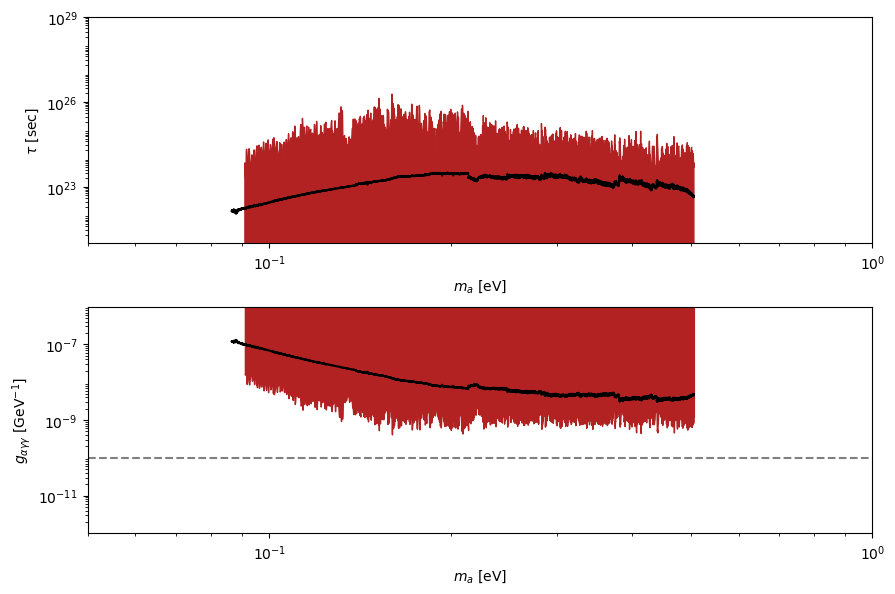

In [91]:
#Plot
plt.figure(figsize=(9, 6))
plt.subplot(211)
plt.fill_between(massArr_ch1_bd,1/gammaBound1_contin,0,color='firebrick')
plt.fill_between(massArr_ch2_bd,1/gammaBound2_contin,0,color='firebrick')
plt.fill_between(massArr_ch3_bd,1/gammaBound3_contin,0,color='firebrick')
plt.fill_between(massArr_ch4_bd,1/gammaBound4_contin,0,color='firebrick')
plt.plot(massArr_ch1,1/gammaBd_ch1,color='black')
plt.plot(massArr_ch2,1/gammaBd_ch2,color='black')
plt.plot(massArr_ch3,1/gammaBd_ch3,color='black')
plt.plot(massArr_ch4,1/gammaBd_ch4,color='black')
plt.xscale('log')
plt.yscale('log')
plt.xlim(5e-2,1)
#plt.xticks((0.1,0.5,0.7,1))
plt.ylim(1e21,1e29)
plt.yticks((1e23,1e26,1e29))
plt.xlabel('$m_a$ [eV]')
plt.ylabel('$\\tau$ [sec]')
# plt.axhline(y = 2e26, color = 'grey', linestyle = '--') 
# plt.axhline(y = 1e24, color = 'grey', linestyle = '--') 

plt.subplot(212)
plt.fill_between(massArr_ch1_bd,couplingBound1_contin,1e-6,color='firebrick')
plt.fill_between(massArr_ch2_bd,couplingBound2_contin,1e-6,color='firebrick')
plt.fill_between(massArr_ch3_bd,couplingBound3_contin,1e-6,color='firebrick')
plt.fill_between(massArr_ch4_bd,couplingBound4_contin,1e-6,color='firebrick')
plt.plot(massArr_ch1,couplingBd_ch1,color='black')
plt.plot(massArr_ch2,couplingBd_ch2,color='black')
plt.plot(massArr_ch3,couplingBd_ch3,color='black')
plt.plot(massArr_ch4,couplingBd_ch4,color='black')
plt.xscale('log')
plt.yscale('log')
plt.xscale('log')
plt.yscale('log')
plt.xlim(5e-2,1)
#plt.xticks((1,3,6))
plt.ylim((1e-12,1e-6))
plt.yticks([1e-11,1e-9,1e-7])
plt.xlabel('$m_a$ [eV]')
plt.ylabel('$g_{\\alpha\\gamma\\gamma}$ [GeV$^{-1}$]')
plt.axhline(y = 1e-10, color = 'grey', linestyle = '--') 
plt.tight_layout(pad=0.9)
plt.savefig('contin_constraint.pdf')

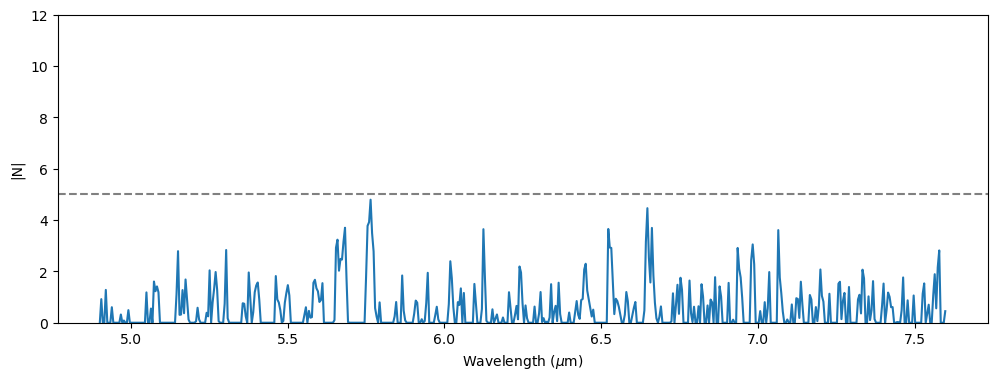

Significant detection:
Strongest detection:
N = 4.79 at (λ_0,i) = ('5.76', 180)


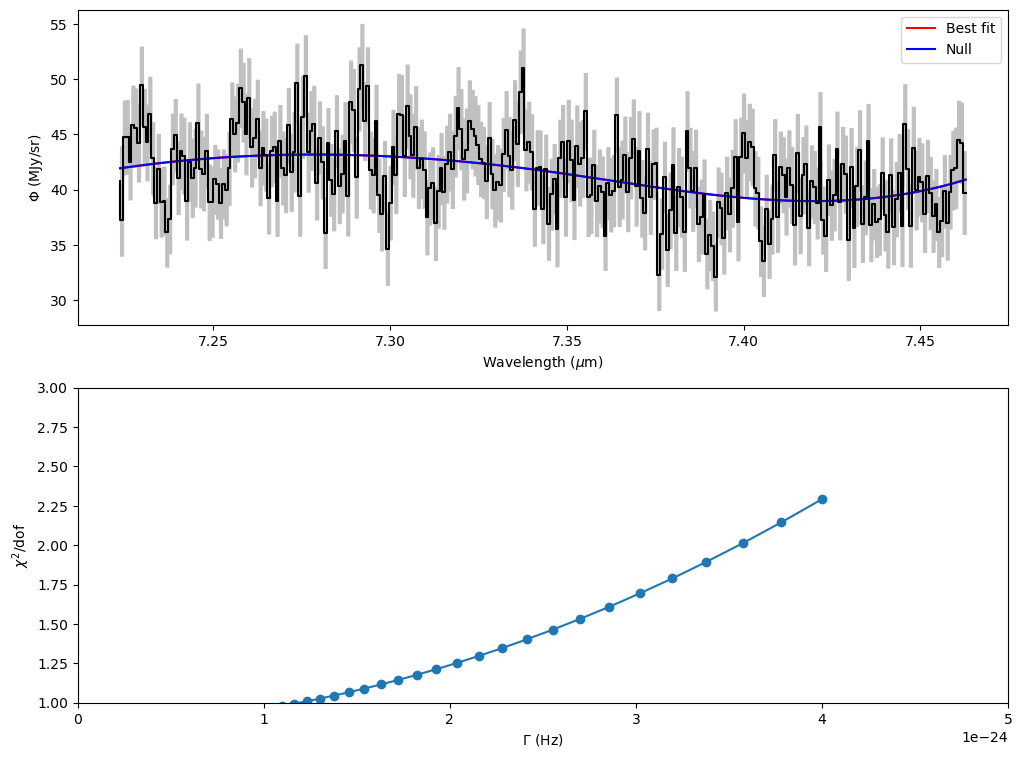

Parameters: [ 0.         41.92646208 43.16088226 41.70746583 39.17241289 40.89670781]
chi2 = 253.7656924484424 N = -0.0


In [101]:
fc1.fitting_result(gammaTest1,plot_i=509,plotFit=True,chi2_LIM=(1,3),CHISQ=chi2_ch1_contin,BETA=beta_ch1,ERRNEW=errorNew_ch1)

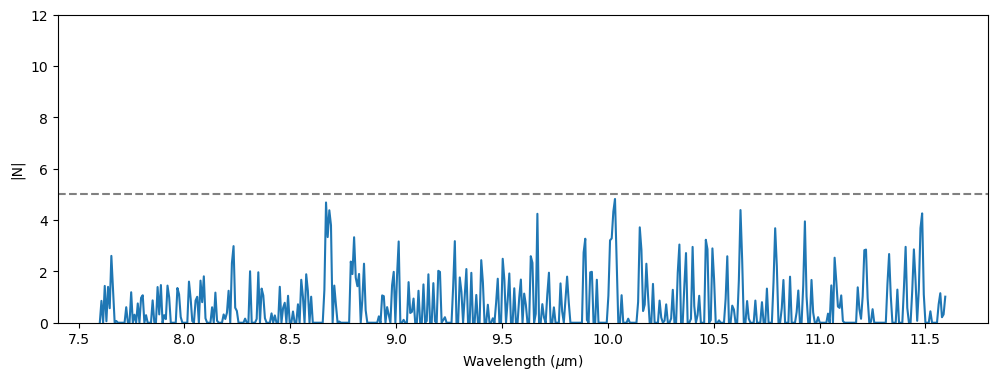

Significant detection:
Strongest detection:
N = 4.82 at (λ_0,i) = ('10.03', 312)


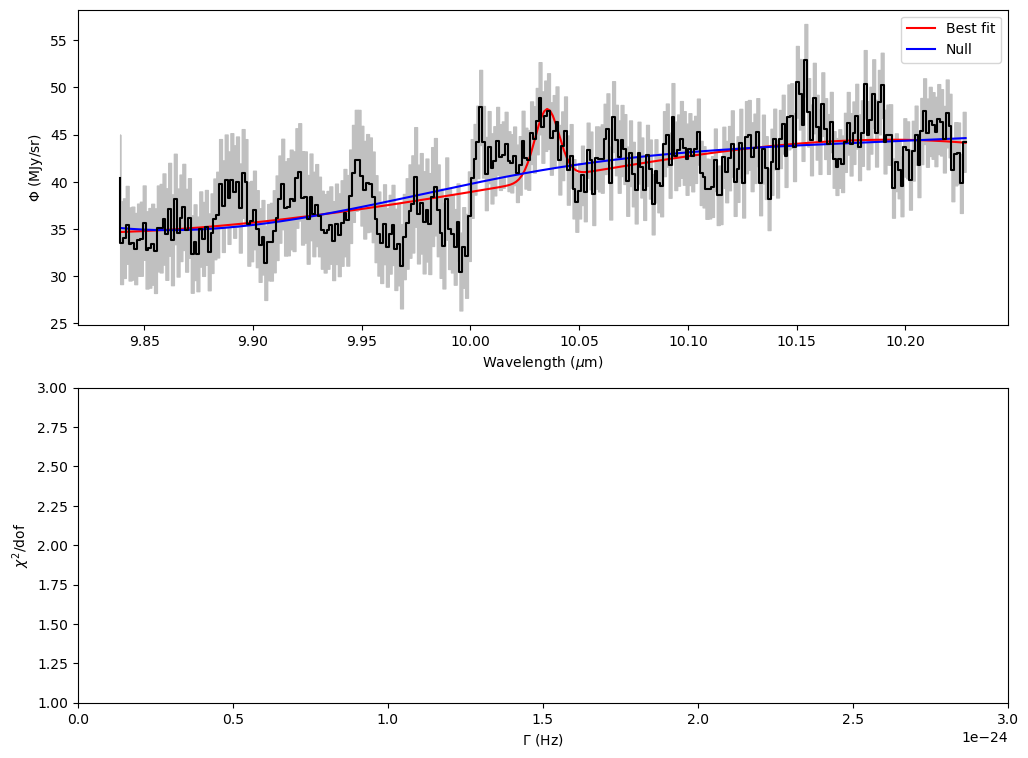

Parameters: [8.77759844e-25 3.46655026e+01 3.66667223e+01 4.02098516e+01
 4.36016309e+01 4.41368967e+01]
chi2 = 153.9342799028791 N = 4.822193289897613


In [103]:
fc2.fitting_result(gammaTest2,plot_i=312,plotFit=True,chi2_LIM=(1,3),gamma_LIM=(0,3e-24),CHISQ=chi2_ch2_contin,BETA=beta_ch2,ERRNEW=errorNew_ch2)

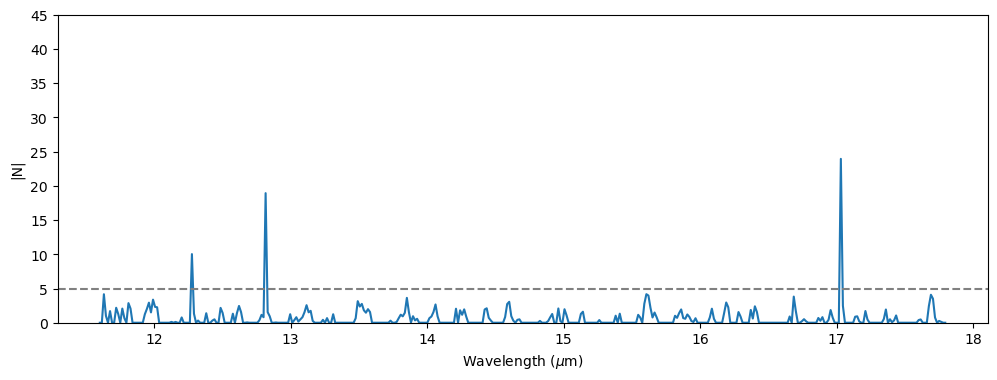

Significant detection:
N = 10.03 at (λ_0,i) = ('12.28', 45)
N = 18.93 at (λ_0,i) = ('12.82', 81)
N = 23.94 at (λ_0,i) = ('17.03', 362)
Strongest detection:
N = 23.94 at (λ_0,i) = ('17.03', 362)


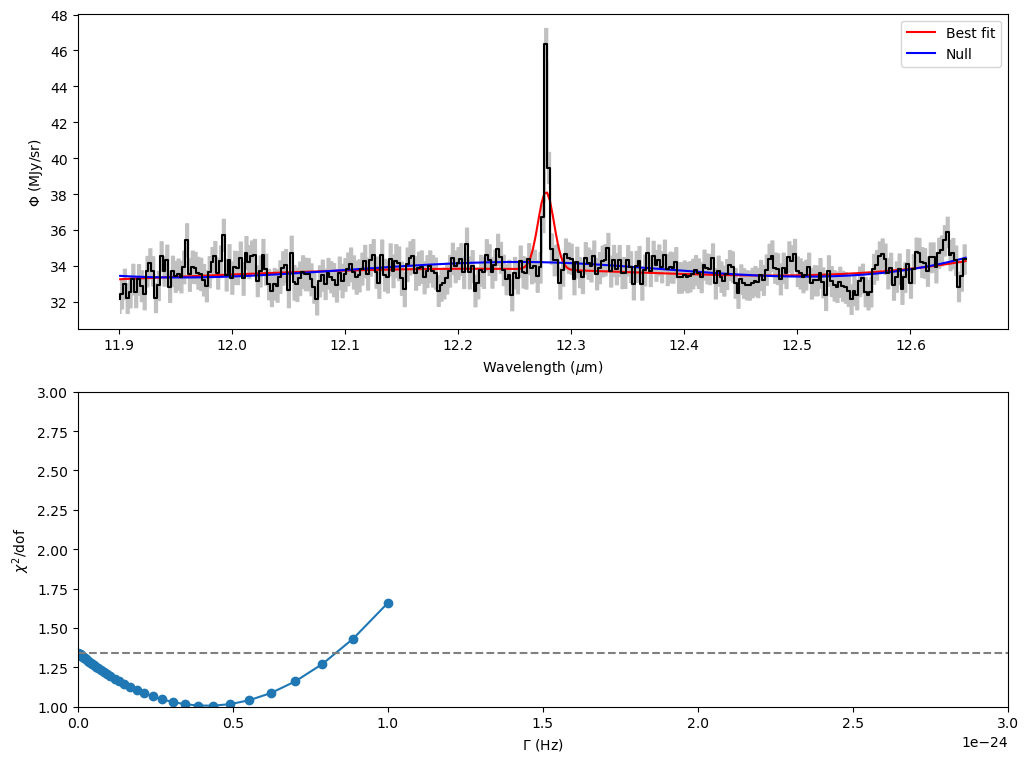

Parameters: [4.36102675e-25 3.32598339e+01 3.37203166e+01 3.38013066e+01
 3.34693058e+01 3.42683020e+01]
chi2 = 301.9817645458371 N = 10.025522520647744


In [107]:
fc3.fitting_result(gammaTest3,plot_i=45,plotFit=True,yLIM=(0,45),chi2_LIM=(1,3),gamma_LIM=(0,3e-24),CHISQ=chi2_ch3_contin,BETA=beta_ch3,ERRNEW=errorNew_ch3)

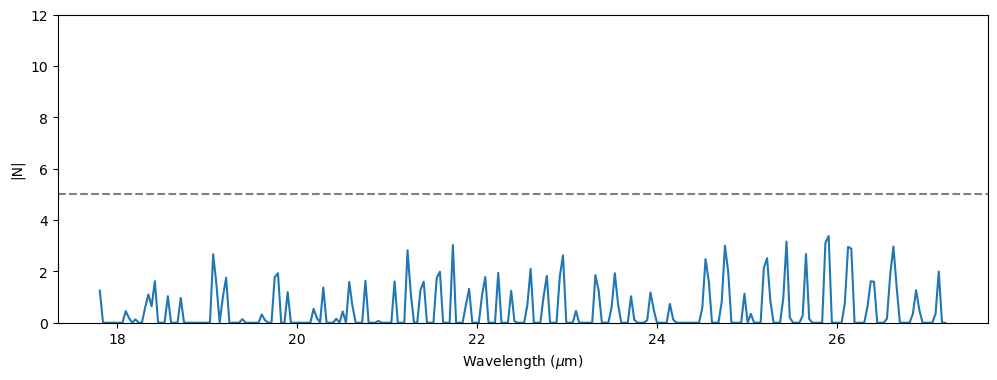

Significant detection:
Strongest detection:
N = nan at (λ_0,i) = ('27.24', 262)


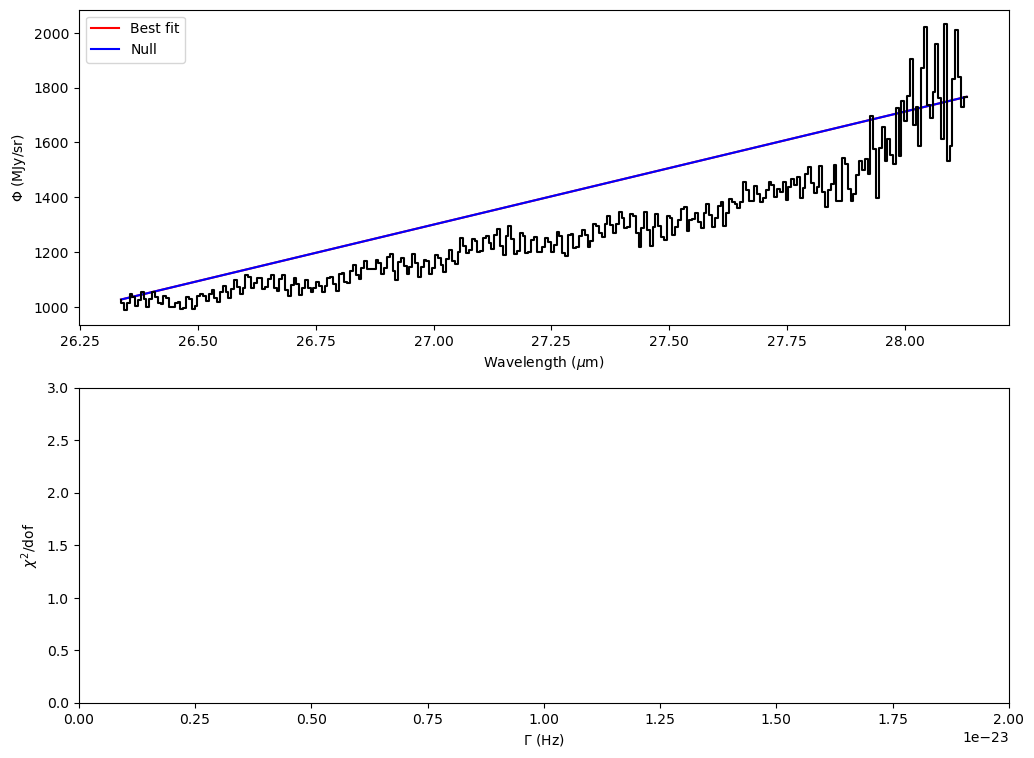

Parameters: [   0.         1026.33676989 1211.30052521 1396.26428053 1581.22803585
 1766.19179118]
chi2 = nan N = nan


In [109]:
fc4.fitting_result(gammaTest4,plot_i=262,plotFit=True,chi2_LIM=(0,3),gamma_LIM=(0,2e-23),CHISQ=chi2_ch4_contin,BETA=beta_ch4,ERRNEW=errorNew_ch4)

Text(0, 0.5, '$|N|$')

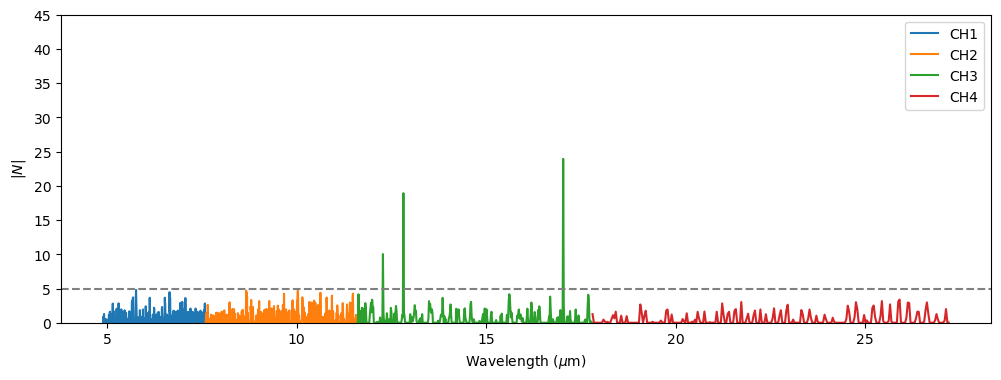

In [110]:
#Detection significance
n2_ch1 = fc1.detection_signif(chi2_ch1_contin,gammaTest1)
n2_ch2 = fc1.detection_signif(chi2_ch2_contin,gammaTest2)
n2_ch3 = fc1.detection_signif(chi2_ch3_contin,gammaTest3)
n2_ch4 = fc1.detection_signif(chi2_ch4_contin,gammaTest4)
plt.figure(figsize=(12,4))
plt.plot(fc1.wvl_bd,np.sqrt(-n2_ch1))
plt.plot(fc2.wvl_bd,np.sqrt(-n2_ch2))
plt.plot(fc3.wvl_bd,np.sqrt(-n2_ch3))
plt.plot(fc4.wvl_bd,np.sqrt(-n2_ch4))
plt.axhline(y = 5, color = 'grey', linestyle = '--') 
plt.ylim((0,45))
plt.legend(('CH1','CH2','CH3','CH4'))
plt.xlabel('Wavelength ($\\mu$m)')
plt.ylabel('$|N|$')

now the fluatuation is too large to provide stronger bounds. 1) require a more accurate model of the background or 2) reduce the fluctuation of the spectrum.

*the only possible detection is at 6.12 microns. Other strong detections do not have resemble a axion decay line. Many strong detections above 5 sig are possible to be eliminated through stacking.